# ส่วนที่ 1 : การวิเคราะห์ภูมิทัศน์งานวิจัยเชิงเปรียบเทียบ

ขั้นตอนที่ 1 : คัดเลือกเเละกรอกข้อมูล
-เลือกกลุ่มเป้าหมาย ทั้งหมด 8 เเห่ง เช่น มหาวิทยาลัยสงขลานครินทร์ , จุฬาลงกรณ์มหาวิทยาลัย , มหาวิทยาลัยมหิดล , มหาวิทยาลัยเชียงใหม่ , มหาวิทยาลัยเทคโนโลยีพระจอมเกล้าธนบุรี , มหาวิทยาลัยขอนแก่น , มหาวิทยาลัยเทคโนโลยีพระจอมเกล้าพระนครเหนือ , มหาวิทยาลัยแม่ฟ้าหลวง
-ระบุเเละสกัดข้อมูล

In [43]:
import json
import csv
from datetime import datetime

# ===== ตั้งค่า =====
input_file = 'arxiv-metadata-oai-snapshot.json'
output_file = 'filtered_arxiv_with_universities2.csv'
target_categories = ['cs.AI', 'cs.LG', 'cs.CV']  # หมวดเป้าหมาย
start_year, end_year = 2014, 2024

# มหาวิทยาลัยเป้าหมาย
target_universities = {
    'PSU': ['Prince of Songkla', 'PSU Thailand', 'Songkla Univ','Prince of Songkla University','PSU'],
    'CU': ['Chulalongkorn University', 'Chula University', 'Chula','CU'],
    'MU': ['Mahidol University', 'Mahidol U', 'Mahidol','MU'],
    'CMU': ['Chiang Mai University', 'CMU','Chiang Mai'],
    'KMUTT': ['King Mongkut\'s University of Technology Thonburi', 'KMUTT'],
    'KKU': ['KKU','Khon Kaen University','Khon Kaen'],
    'KMUTNB': ['KMUTNB','King Mongkut\'s University of Technology North Bangkok'],
    'MFU': ['MFU','Mae Fah Luang University','Mae Fah Luang']
}

def find_affiliated_university(authors_text):
    if not authors_text:
        return None
    text = str(authors_text).lower()
    for uni_code, uni_names in target_universities.items():
        for name in uni_names:
            if name.lower() in text:
                return uni_code
    return None

# ===== เขียน Header CSV =====
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'title', 'categories', 'update_date', 'abstract', 'authors', 'university_code'])

# ===== อ่านไฟล์แบบ Streaming =====
with open(input_file, 'r', encoding='utf-8') as f:
    count = saved = 0

    for line in f:
        count += 1
        try:
            record = json.loads(line)
        except json.JSONDecodeError:
            continue

        # --- 1️⃣ กรองหมวดหมู่ ---
        categories = record.get('categories', '')
        if not any(cat in categories for cat in target_categories):
            continue

        # --- 2️⃣ กรองปี ---
        date_str = record.get('update_date', '')
        try:
            year = datetime.strptime(date_str, '%Y-%m-%d').year
        except:
            continue
        if year < start_year or year > end_year:
            continue

        # --- 3️⃣ ตรวจสอบมหาวิทยาลัยใน authors ---
        authors_text = record.get('authors', '') or record.get('authors_parsed', '')
        uni_code = find_affiliated_university(authors_text)
        if not uni_code:
            continue  # ไม่มีมหาวิทยาลัยเป้าหมาย → ข้าม

        # --- 4️⃣ เขียนบรรทัดลง CSV ---
        authors_clean = str(record.get('authors', '')).replace('\n', ' ').strip()

        with open(output_file, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                record.get('id', ''),
                record.get('title', '').replace('\n', ' '),
                categories,
                date_str,
                record.get('abstract', '').replace('\n', ' '),
                authors_clean,
                uni_code
            ])
        saved += 1

        if count % 100000 == 0:
            print(f'อ่านแล้ว {count:,} บรรทัด | เก็บไว้ {saved:,} บทความ')

print(f'✅ เสร็จสิ้น! เก็บข้อมูล {saved:,} บทความจากมหาวิทยาลัยเป้าหมาย')
print(f'📄 ไฟล์ที่ได้: {output_file}')


✅ เสร็จสิ้น! เก็บข้อมูล 26,547 บทความจากมหาวิทยาลัยเป้าหมาย
📄 ไฟล์ที่ได้: filtered_arxiv_with_universities2.csv


In [45]:
# =============================
# 📊 EDA & Visualization for ArXiv Filtered Dataset
# =============================
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import Counter

# 📌 1) Load dataset
csv_path = 'filtered_arxiv_with_universities2.csv'   # เปลี่ยน path ให้ถูกต้อง
df = pd.read_csv(csv_path, dtype=str, low_memory=False)

# --- Cleaning & preparation ---
df['update_date'] = pd.to_datetime(df['update_date'], errors='coerce')
df['year'] = df['update_date'].dt.year
df['categories'] = df['categories'].fillna('')
df['authors'] = df['authors'].fillna('')

print("✅ Dataset loaded")
print("Records:", len(df))
print("Universities distribution:")
print(df['university_code'].value_counts())

✅ Dataset loaded
Records: 26547
Universities distribution:
university_code
MU     18087
CU      8322
KKU      129
PSU        8
MFU        1
Name: count, dtype: int64


ขั้นตอนที่ 2 : วิเคราะห์ข้อมูลเชิงสำรวจเปรียบเทียบ

In [ ]:
-ปริมาณผลงาน: เปรียบเทียบจำนวนผลงานตีพิมพ์ในแต่ละปีของแต่ละมหาวิทยาลัย 

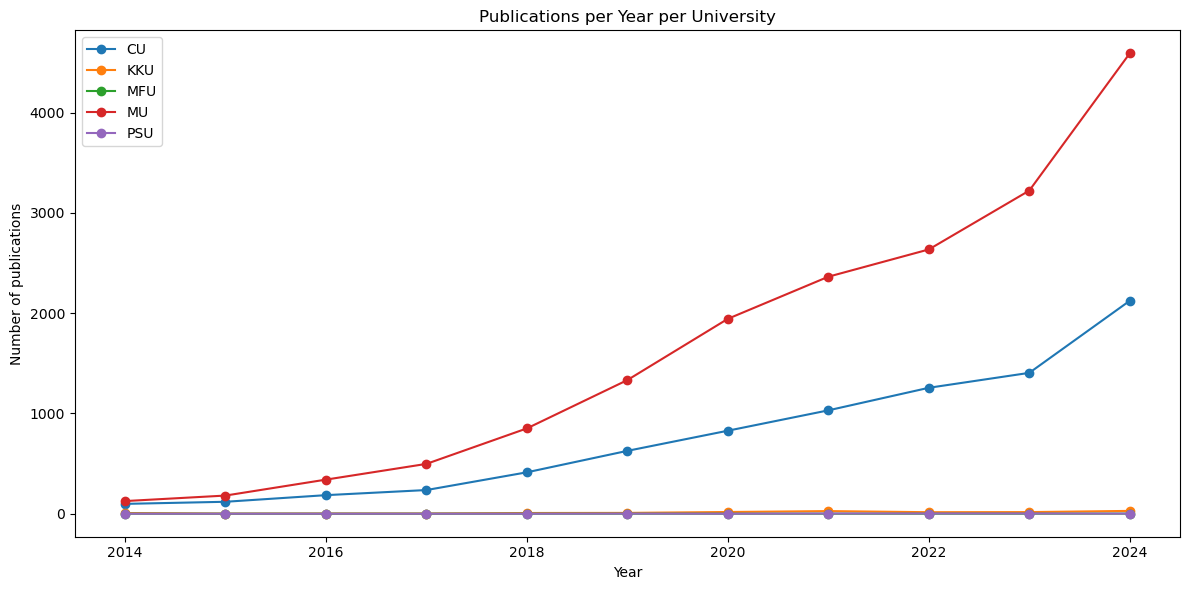

In [47]:
# 📈 2) Publications per year per university
# =============================
pubs_per_year = df.groupby(['university_code', 'year']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for uni in pubs_per_year.index:
    plt.plot(pubs_per_year.columns, pubs_per_year.loc[uni], marker='o', label=uni)
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per Year per University')
plt.legend()
plt.tight_layout()
plt.show()

-สาขาที่โดดเด่น: วิเคราะห์และแสดงภาพเปรียบเทียบหมวดหมู่งานวิจัย (Categories) ที่แต่ละมหาวิทยาลัยให้ความสำคัญ 

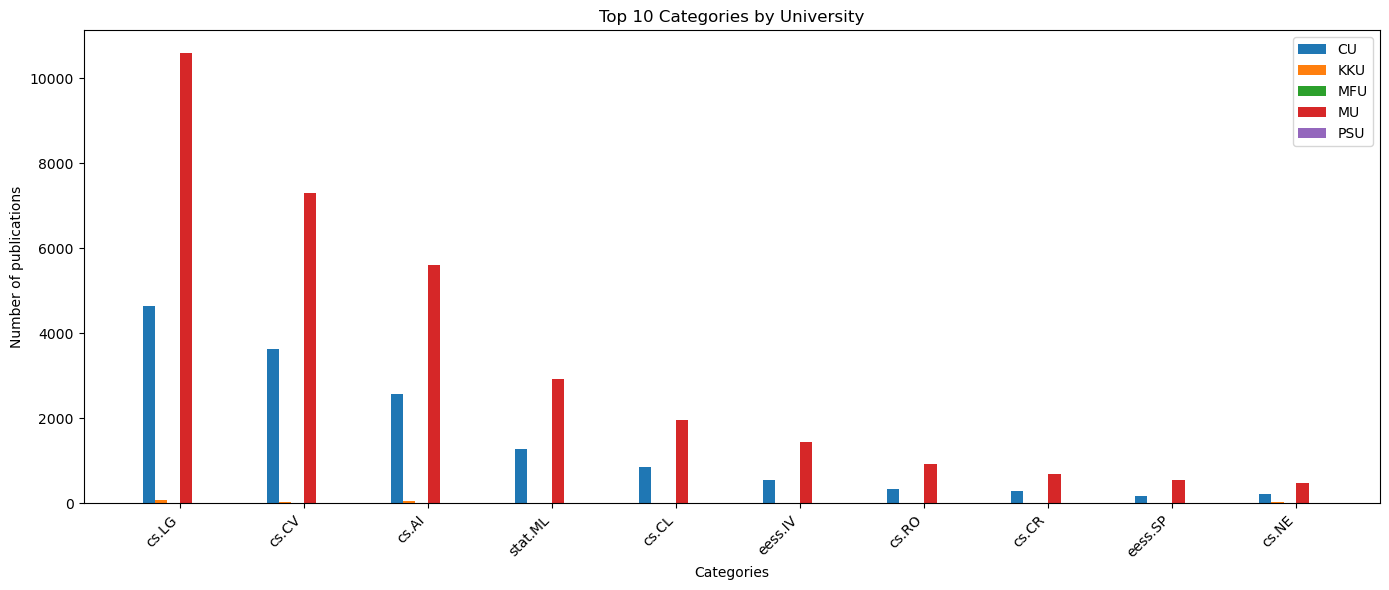

In [49]:
# 🧠 3) Top Categories per University
# =============================
# แยก categories ออกเป็น list
def split_categories(cat_str):
    if not isinstance(cat_str, str):
        return []
    return [c.strip() for c in cat_str.split() if c.strip()]

df['cat_list'] = df['categories'].apply(split_categories)
df_exploded = df.explode('cat_list')

# เลือก Top 10 categories ทั้ง dataset
top_categories = (
    df_exploded['cat_list'].value_counts()
    .head(10)
    .index
    .tolist()
)

# นับจำนวนของแต่ละ category ต่อมหาวิทยาลัย
cats_by_uni = {}
for uni in df['university_code'].unique():
    subset = df_exploded[df_exploded['university_code'] == uni]
    cnt = Counter(subset['cat_list'])
    cats_by_uni[uni] = [cnt.get(c, 0) for c in top_categories]

# วาดกราฟแบบ grouped bar chart
plt.figure(figsize=(14, 6))
x = range(len(top_categories))
width = 0.1

for i, uni in enumerate(sorted(cats_by_uni.keys())):
    offsets = [xi + (i - len(cats_by_uni)/2)*width for xi in x]
    plt.bar(offsets, cats_by_uni[uni], width=width, label=uni)

plt.xticks(x, top_categories, rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Number of publications')
plt.title('Top 10 Categories by University')
plt.legend()
plt.tight_layout()
plt.show()

เครือข่ายความร่วมมือ: วิเคราะห์เบื้องต้นเกี่ยวกับเครือข่ายผู้เขียนร่วม (Co-authorship) เพื่อดูรูปแบบความร่วมมือภายในและระหว่างสถาบัน

Total authors in graph: 82235


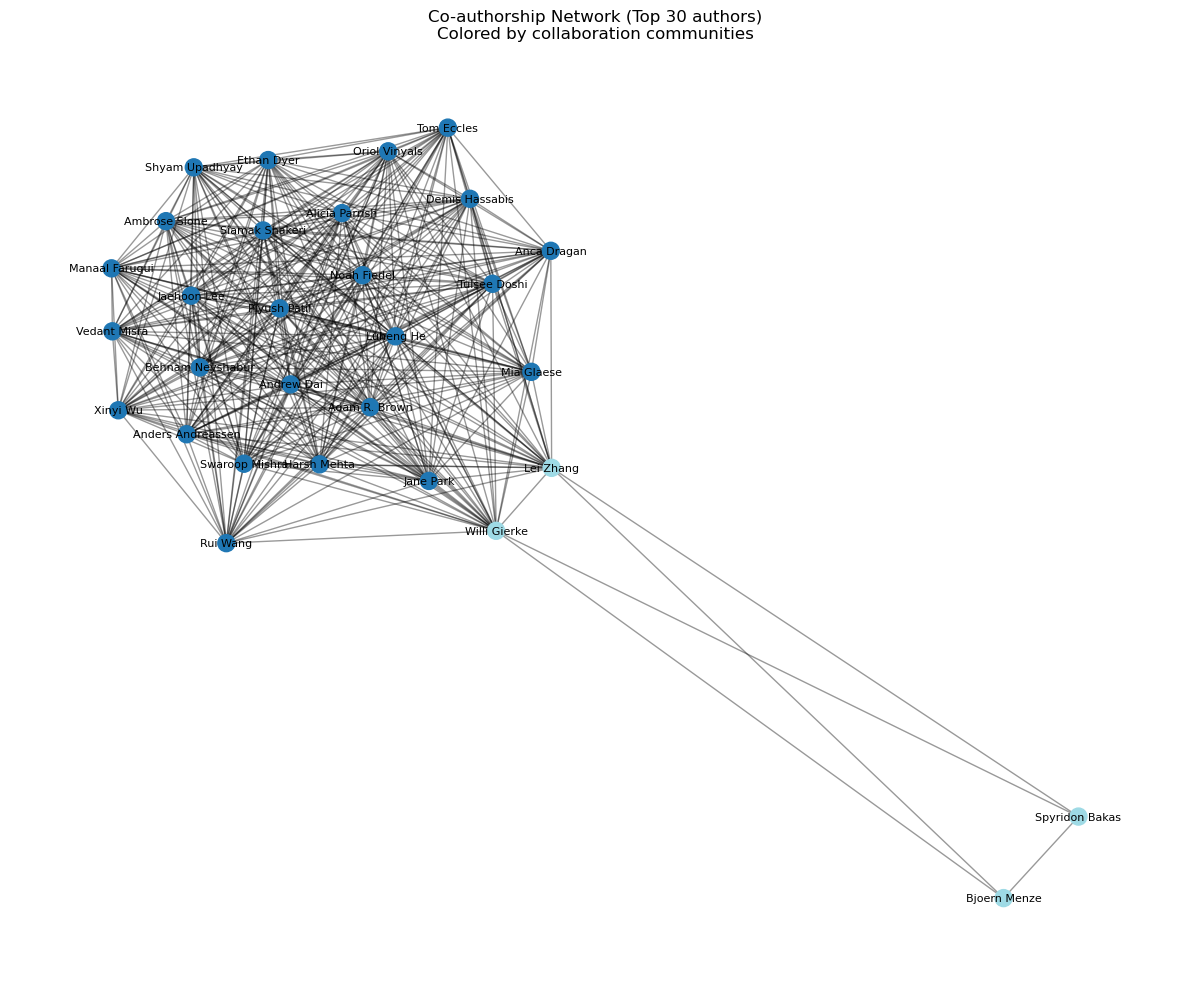

In [51]:
# 👥 4) Co-authorship Network (Author-level)
# =============================
from networkx.algorithms import community
import matplotlib.cm as cm

def split_authors(s):
    """Split authors string into list"""
    if not isinstance(s, str) or s.strip() == '':
        return []
    # split by common separators
    if ';' in s:
        return [a.strip() for a in s.split(';') if a.strip()]
    if ' and ' in s:
        return [a.strip() for a in s.split(' and ') if a.strip()]
    if ',' in s:
        return [a.strip() for a in s.split(',') if a.strip()]
    return [s.strip()]

G = nx.Graph()

for _, row in df.iterrows():
    authors = split_authors(row['authors'])
    authors = [a for a in authors if a != '']
    for a in authors:
        if not G.has_node(a):
            G.add_node(a)
    for a, b in combinations(authors, 2):
        if G.has_edge(a, b):
            G[a][b]['weight'] += 1
        else:
            G.add_edge(a, b, weight=1)

print(f"Total authors in graph: {len(G)}")

# วาดกราฟเฉพาะ top 30 nodes ที่มี degree สูงสุด
deg = dict(G.degree())
top_authors = sorted(deg, key=deg.get, reverse=True)[:30]
subG = G.subgraph(top_authors)

subG = G.subgraph(top_authors).copy()
communities = list(community.greedy_modularity_communities(subG))

# สร้าง mapping: node -> community index
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

colors = [community_map[node] for node in subG.nodes()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, seed=42)
nx.draw_networkx_nodes(subG, pos, node_color=colors, cmap=cm.tab20, node_size=150)
nx.draw_networkx_edges(subG, pos, alpha=0.4)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.title('Co-authorship Network (Top 30 authors)\nColored by collaboration communities')
plt.axis('off')
plt.tight_layout()
plt.show()


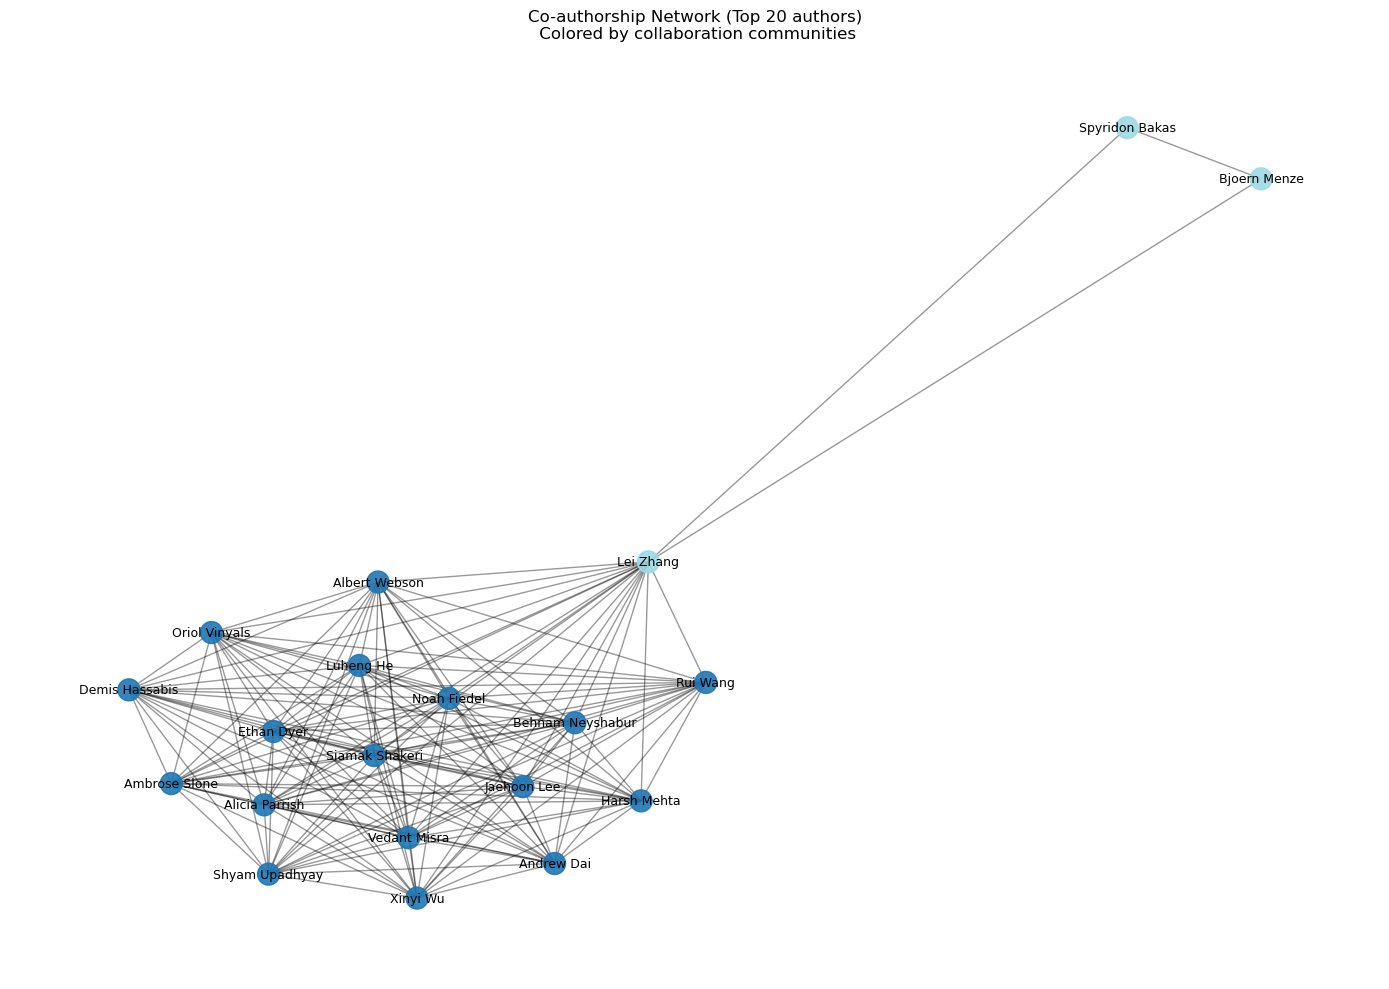

In [11]:
from networkx.algorithms import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# --- 1) เลือก Top 20 authors ---
deg = dict(G.degree())
top_authors = sorted(deg, key=deg.get, reverse=True)[:20]
subG = G.subgraph(top_authors).copy()

# --- 2) หา communities ---
communities = list(community.greedy_modularity_communities(subG))
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
colors = [community_map[node] for node in subG.nodes()]

# --- 3) Layout: ปรับ k ให้ node ห่างขึ้น ---
# ค่า k เริ่มต้นของ nx.spring_layout คือ 1/sqrt(n)
# ลองเพิ่มเป็น 0.5 - 1.5 เพื่อให้ node กระจายตัวมากขึ้น
pos = nx.spring_layout(subG, seed=42, k=0.7, iterations=100)

# --- 4) วาดกราฟ ---
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(subG, pos, node_color=colors, cmap=cm.tab20, node_size=250, alpha=0.9)
nx.draw_networkx_edges(subG, pos, alpha=0.4)
nx.draw_networkx_labels(subG, pos, font_size=9)

plt.title('Co-authorship Network (Top 20 authors)\n Colored by collaboration communities')
plt.axis('off')
plt.tight_layout()
plt.show()


# ส่วนที่ 2 การสร้างแบบจำลองทำนายศักยภาพ

ขั้นตอนที่ 3: นิยาม "ผลกระทบ" เเละเตรียมข้อมูล
-สกัดข้อมูลเพิ่มจากข้อมูลเดิม
-กำหนดตัวแปรเป้าหมาย

In [53]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv('filtered_arxiv_with_universities.csv')

# 1. จำนวนผู้เขียน
df['num_authors'] = df['authors'].fillna('').apply(lambda x: len(x.split(',')))

# 2. ความยาวบทคัดย่อ
df['abstract_length'] = df['abstract'].fillna('').apply(lambda x: len(x.split()))

# 3. หมวดหมู่ (แยกเป็น list แล้ว one-hot)
df['categories_list'] = df['categories'].apply(lambda x: x.split())
mlb = MultiLabelBinarizer()
cat_df = pd.DataFrame(mlb.fit_transform(df['categories_list']), columns=mlb.classes_)
df = pd.concat([df, cat_df], axis=1)

# 4. ปี
df['year'] = pd.to_datetime(df['update_date']).dt.year

# 5. Target
# 1️⃣ เงื่อนไขปี 2020–2024 → ให้ค่าเริ่มต้น 1
# ✅ เริ่มจากเงื่อนไขปี 2020–2024
df['impact_label'] = ((df['year'] >= 2020) & (df['year'] <= 2024)).astype(int)

# ✅ หาคอลัมน์ทั้งหมดที่ขึ้นต้นด้วย 'cs.'
cs_columns = ['cs.AI', 'cs.LG', 'cs.CV']

# ✅ บวกคะแนนเพิ่มตามจำนวนสาขา cs. ที่มีค่า 1
df['impact_label'] += df[cs_columns].sum(axis=1)




In [55]:
df

,id,title,categories,update_date,abstract,authors,university_code,num_authors,abstract_length,categories_list,...,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,year,impact_label
0,0704.3746,Distributed Algorithms for Spectrum Allocation...,cs.NI,2016-11-15,We develop distributed algorithms to allocat...,"Yufang Xi, Edmund M. Yeh",MU,2,154,[cs.NI],...,0,0,0,0,0,0,0,0,2016,0
1,0705.0123,An Energy Efficiency Perspective on Training f...,cs.IT math.IT,2016-11-17,"In this paper, the bit energy requirements o...",Mustafa Cenk Gursoy,MU,1,156,"[cs.IT, math.IT]",...,0,0,0,0,0,0,0,0,2016,0
2,0705.0124,On the Low-SNR Capacity of Phase-Shift Keying ...,cs.IT math.IT,2016-11-17,The low-snr capacity of M-ary PSK transmissi...,Mustafa Cenk Gursoy,MU,1,103,"[cs.IT, math.IT]",...,0,0,0,0,0,0,0,0,2016,0
3,0705.0128,Training Optimization for Gauss-Markov Rayleig...,cs.IT math.IT,2016-11-17,"In this paper, pilot-assisted transmission o...","Sami Akin, Mustafa Cenk Gursoy",MU,2,117,"[cs.IT, math.IT]",...,0,0,0,0,0,0,0,0,2016,0
4,0705.0130,Performance Analysis for Multichannel Receptio...,cs.IT math.IT,2016-11-17,"In this paper, the error performance of on-o...","Qingyun Wang, Mustafa Cenk Gursoy",MU,2,146,"[cs.IT, math.IT]",...,0,0,0,0,0,0,0,0,2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49606,quant-ph/0412088,Quantum and Classical Communication-Space Trad...,quant-ph cs.CC,2016-09-08,We derive lower bounds for tradeoffs between...,Hartmut Klauck,MU,1,133,"[quant-ph, cs.CC]",...,0,1,0,0,0,0,0,0,2016,0
49607,quant-ph/0502101,Thresholds for Linear Optics Quantum Computing...,quant-ph cs.ET,2023-11-27,We calculate the error threshold for the lin...,"Marcus Silva, Martin Roetteler, Christof Zalka",CU,3,134,"[quant-ph, cs.ET]",...,0,1,0,0,0,0,0,0,2023,1
49608,quant-ph/0603135,Interaction in Quantum Communication,quant-ph cs.CC cs.IT math.IT,2018-03-22,In some scenarios there are ways of conveyin...,"Hartmut Klauck, Ashwin Nayak, Amnon Ta-Shma an...",MU,3,154,"[quant-ph, cs.CC, cs.IT, math.IT]",...,0,1,0,0,0,0,0,0,2018,0
49609,quant-ph/0605030,Strongly Universal Quantum Turing Machines and...,quant-ph cs.IT math-ph math.IT math.MP,2016-11-18,We show that there exists a universal quantu...,Markus Mueller,MU,1,148,"[quant-ph, cs.IT, math-ph, math.IT, math.MP]",...,0,1,0,0,0,0,0,0,2016,0


บทความที่มีผลกระทบสูง คือบทความที่มี impact สูง วิธีการคือหากบทความอยู่ในช่วงปี 2020 ถึงปี 2024 ให้1 หากไม่อยู่ในช่วงปีนั้นให้ 0 เเละถ้าบทความนั้นอยู่ในสาขา cs.AI , cs.LG , cs.CV ให้สาขาอย่างละ 1 เพิ่มขึ้นหากมีเงื่อนไขเป็นไปตามข้อความข้างต้นในคอลัมน์ impact_label

In [ ]:
ขั้นตอนที่ 4: สร้างเเบบจำลองพื้นฐาน (Baseline Model)
-Feature Engineering
-สร้างเเบบจำลอง

Step 1 — เตรียมข้อมูล

In [59]:
# ✅ กำหนด features และ target
target = 'impact_label'

# เลือก features ที่สำคัญ
text_features = ['title', 'abstract']
numeric_features = ['year', 'num_authors', 'abstract_length']
categorical_features = ['university_code']

# One-hot categories เช่น cs.AI, cs.LG, ...
category_cols = ['cs.AI', 'cs.LG', 'cs.CV']

X = df[text_features + numeric_features + categorical_features + category_cols]
y = df[target]


Step 2 — แบ่งชุด Train/Test

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


ขั้นตอนที่ 5: เพิ่มประสิทธิภาพด้วยข้อมูลจากข้อความ
-Feature Engineering

Step 3 — สร้าง Baseline Model (Logistic Regression)

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', TfidfVectorizer(max_features=3000, stop_words='english'), 'title'),
        ('abstract_tfidf', TfidfVectorizer(max_features=5000, stop_words='english'), 'abstract'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features + category_cols)
    ]
)

# ✅ Logistic Regression Baseline
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1547
           1       1.00      1.00      1.00      3893
           2       1.00      1.00      1.00      3201
           3       1.00      0.99      0.99      1143
           4       0.96      1.00      0.98       139

    accuracy                           1.00      9923
   macro avg       0.99      1.00      0.99      9923
weighted avg       1.00      1.00      1.00      9923



Step 4 — ประเมินผล

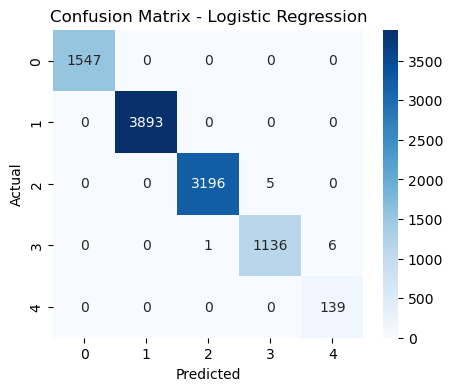

In [65]:
from sklearn.metrics import roc_auc_score

# AUC (สำหรับ classification)
if len(y.unique()) == 2:  # เฉพาะ binary
    y_prob = model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Step 5 — สร้างเเบบจำลอง LightGBM

In [67]:
!pip install lightgbm

In [69]:
import lightgbm as lgb

lgbm_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42
    ))
])

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

print("LightGBM model performance:")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.883307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639601
[LightGBM] [Info] Number of data points in the train set: 39688, number of used features: 7295
[LightGBM] [Info] Start training from score -1.858922
[LightGBM] [Info] Start training from score -0.935639
[LightGBM] [Info] Start training from score -1.131213
[LightGBM] [Info] Start training from score -2.161536
[LightGBM] [Info] Start training from score -4.266239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in